<a href="https://www.kaggle.com/code/artemsilvander/face-recognition-age-detect-and-predict-on-raw?scriptVersionId=119612180" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Face detection

In [3]:
# face detection function using MTCNN pre-trained model

!pip install mtcnn

import cv2
from mtcnn import MTCNN
from IPython.display import Image

def detect_faces(image_path, detection_confidence=0.99, min_face_size=10):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create an MTCNN detector instance
    detector = MTCNN()

    # Use the detector to detect faces in the image
    faces = detector.detect_faces(image)

    # Draw a square around each face
    for face in faces:
        if face['confidence'] < detection_confidence:
            continue
        x, y, width, height = face['box']
        if min(width, height) < min_face_size:
            continue
        face_size = max(width, height)
        x, y = x + (width - face_size) // 2, y + (height - face_size) // 2
        cv2.rectangle(image, (x, y), (x + face_size, y + face_size), (127, 255, 0), 3)

    # Save the image with the detected faces to a file
    cv2.imwrite("detected_faces.jpg", image)

    # Return the path to the saved file
    return "detected_faces.jpg"


ModuleNotFoundError: No module named 'tensorflow'

In [6]:
from IPython.display import Image

# Detect faces in the image of my friends / many faces / low light
image_path = detect_faces('/kaggle/input/my-team/my_team.jpg')

# Display the saved image
Image(filename=image_path)

NameError: name 'detect_faces' is not defined

# Model for Age prediction

In [7]:


# Preprocess the data

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


df = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

# Set y
y = df['age'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=123)

ModuleNotFoundError: No module named 'seaborn'

NameError: name 'df' is not defined

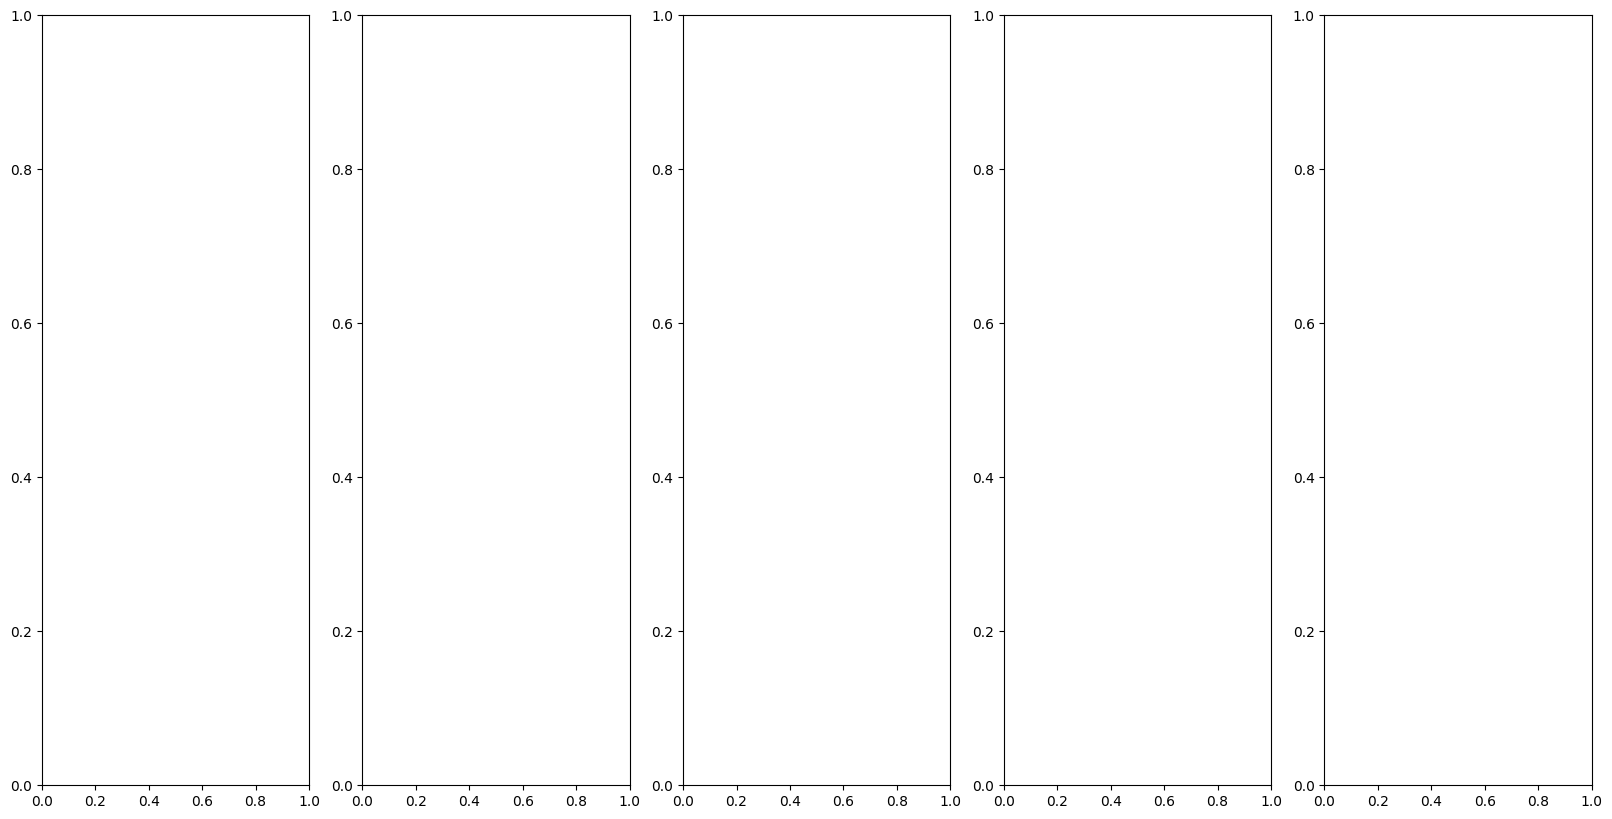

In [8]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

In [5]:
# CNN model structure

age_model_3 = Sequential()

age_model_3.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.3))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.3))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.5))
age_model_3.add(BatchNormalization())

age_model_3.add(Flatten())
age_model_3.add(Dense(128, activation='relu'))
age_model_3.add(Dropout(0.4))
age_model_3.add(Dense(1))

age_model_3.compile(optimizer='adam', loss='mean_absolute_error')

age_model_3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)      0

In [6]:
# callbacks and history run (train the model)

callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

history = age_model_3.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 7s 18ms/step - loss: 11.3633 - val_loss: 26.0696 - lr: 0.0010
Epoch 2/35
297/297 [==============================] - 5s 16ms/step - loss: 8.7596 - val_loss: 39.4545 - lr: 0.0010
Epoch 3/35
297/297 [==============================] - 5s 16ms/step - loss: 8.0946 - val_loss: 7.1237 - lr: 0.0010
Epoch 4/35
297/297 [==============================] - 4s 15ms/step - loss: 7.7604 - val_loss: 7.9814 - lr: 0.0010
Epoch 5/35
293/297 [============================>.] - ETA: 0s - loss: 7.3832
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
297/297 [==============================] - 4s 15ms/step - loss: 7.3869 - val_loss: 12.6787 - lr: 0.0010
Epoch 6/35
297/297 [==============================] - 5s 16ms/step - loss: 6.8991 - val_loss: 8.4006 - lr: 5.0000e-04
Epoch 7/35
293/297 [============================>.] - ETA: 0s - loss: 6.6036
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
297/297 [====

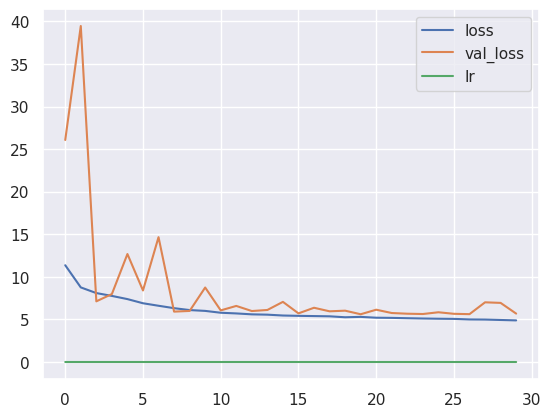

In [7]:
# plotting the results

pd.DataFrame(history.history).plot();

In [8]:
# evaluationg R2 score

from sklearn.metrics import r2_score

# Make predictions 
y_pred = age_model_3.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 1s 3ms/step
R2 score: 0.840


In [9]:
# saving the model

age_model_3.save('/kaggle/working/age_model_3.h5')

# Detect + predict

In [10]:
# function that use MTCNN face detection and pass detected area to our age_model_3 for recognition

import cv2
import numpy as np
from mtcnn import MTCNN
from IPython.display import Image

def detect_faces_age(image_path, detection_confidence=0.99, min_face_size=10, age_model=None):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create an MTCNN detector instance
    detector = MTCNN()

    # Use the detector to detect faces in the image
    faces = detector.detect_faces(image)

    # Loop over the detected faces
    for face in faces:
        # Check the confidence score of the detection
        if face['confidence'] < detection_confidence:
            continue
        # Extract the bounding box coordinates
        x, y, width, height = face['box']
        # Check the size of the bounding box
        if min(width, height) < min_face_size:
            continue
        
        # Extract the face region from the image
        face_image = image[y:y+height, x:x+width]
        # Resize the face image to 48x48 and convert to grayscale
        face_image_resized = cv2.resize(face_image, (48, 48))
        face_image_gray = cv2.cvtColor(face_image_resized, cv2.COLOR_BGR2GRAY)
        # Reshape the face image to match the input shape of the model
        face_image_reshaped = face_image_gray.reshape((1, 48, 48, 1))
        if np.max(face_image_reshaped) > 1: face_image_reshaped = face_image_reshaped / 255
        
        # Use the model to predict the age of the face
        predicted_age = age_model_3.predict(face_image_reshaped)[0][0]
        
        # Draw the predicted age on the input image
        cv2.putText(image, "{:.1f}".format(predicted_age), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
        # Draw a square rectangle around the face
        face_size = min(width, height)
        x_center = x + int(width / 2)
        y_center = y + int(height / 2)
        x1 = x_center - int(face_size / 2)
        y1 = y_center - int(face_size / 2)
        x2 = x_center + int(face_size / 2)
        y2 = y_center + int(face_size / 2)
        cv2.rectangle(image, (x1, y1), (x2, y2), (127, 255, 0), 3)

    # Save the image with the detected faces and predicted ages to a file
    cv2.imwrite("detected_faces.jpg", image)

    # Return the path to the saved file
    return "detected_faces.jpg"


1/1 [==============================] - 0s 15ms/step


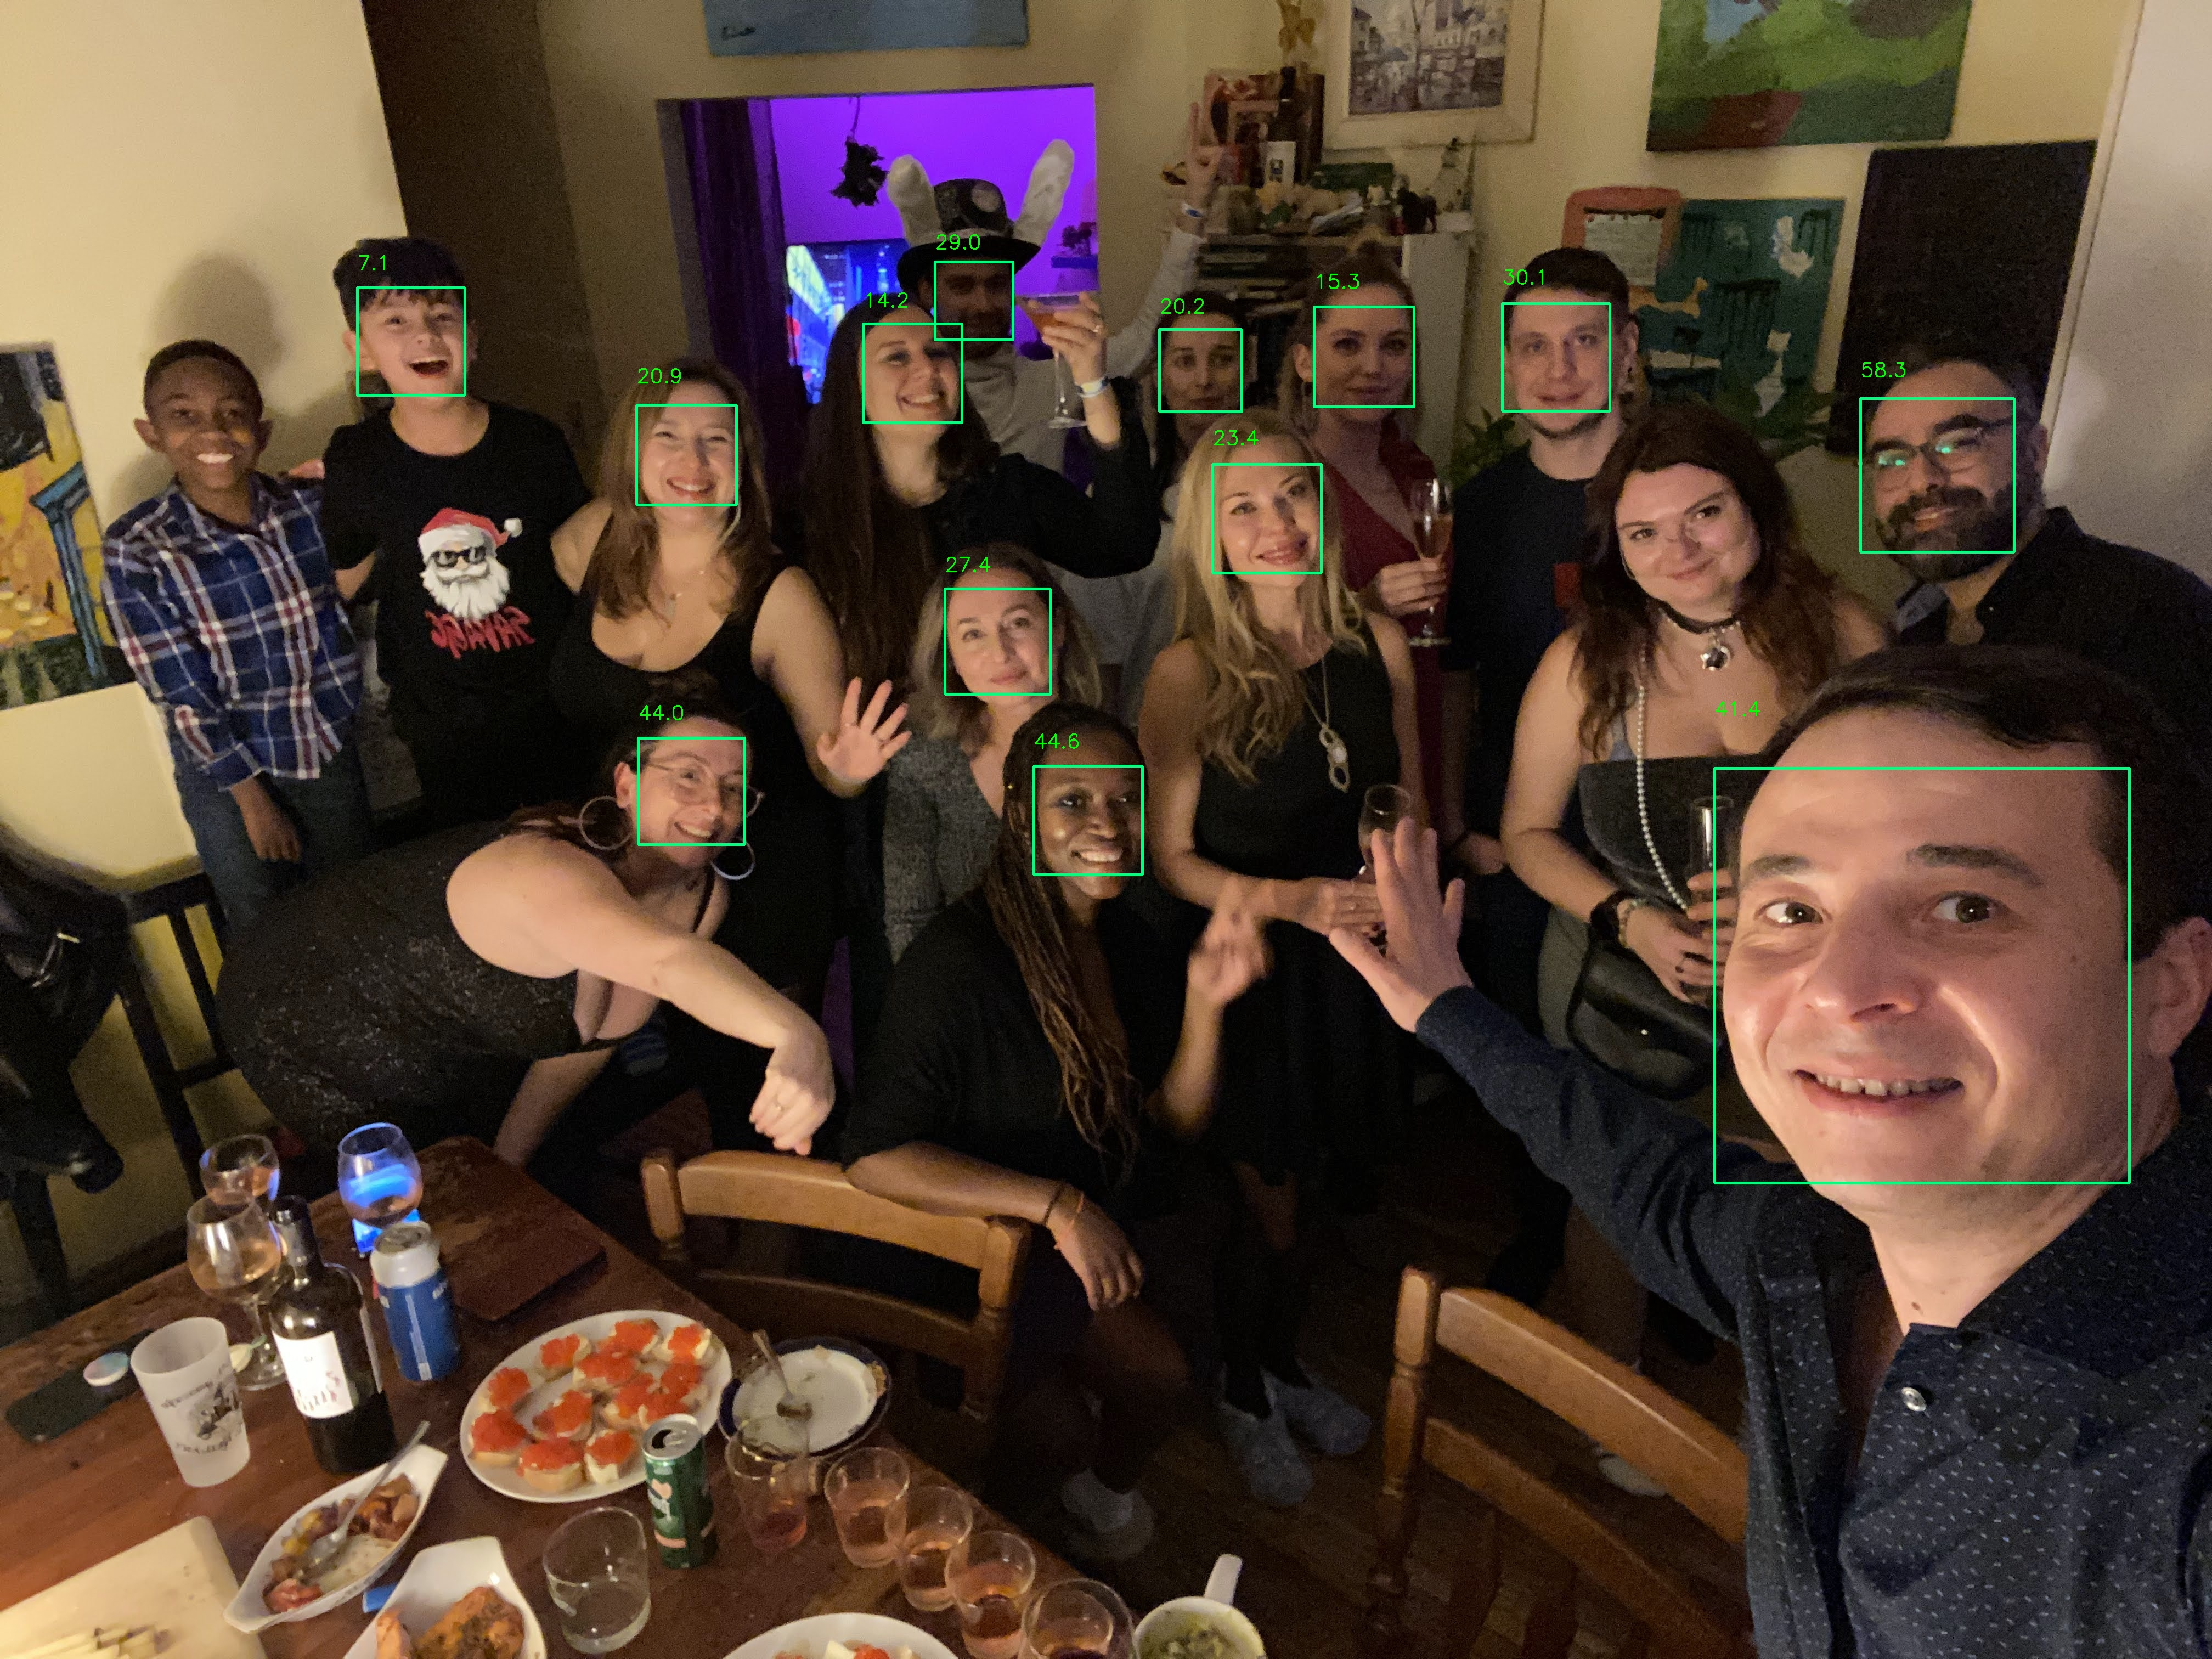

In [11]:
# Detect faces in the new image of my friends and save the result to a file
image_path = detect_faces_age('/kaggle/input/my-team/my_team.jpg')

# Display the saved image
Image(filename=image_path)

# Further steps 

Looks interesting, isn't it?  Most faces predicted accurately. 
Though the model like that is not good enough for production level. This is just demonstration.

Obviously, the model was trained on small dataset available for demo and study purposes.
In order to improve the model there are furtherv steps:

    1. Train the model on bigger and more versatile dataset.
    3. Improve the CNN model
    2. Use pre-trained models like VGG16, etc.
    
Please UPVOTE if my notebook helped you!